In [1]:
import csv as csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
from sklearn.preprocessing import MinMaxScaler
import scipy.optimize as opt  

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Reading using numpy arrays

data=[] 
csv_file_object = csv.reader(open('./data/train.csv', 'r')) 
for row in csv_file_object:
    data.append(row)
data = np.array(data) 



In [3]:
# Reading using pandas

df = pd.read_csv('./data/train.csv', header=0)
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


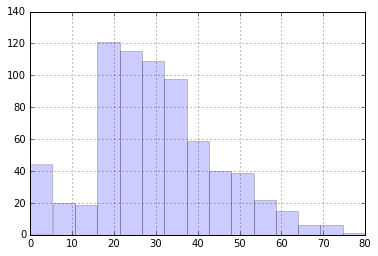

In [5]:
import pylab as P

df['Age'].dropna().hist(bins=15, range=(0,80), alpha = .2)

P.show()

In [6]:
df['Gender'] = df['Sex'].map({'male': 1, 'female': 0}).astype(int)

In [29]:
median_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = df[(df['Gender'] == i) & \
                              (df['Pclass'] == j+1)]['Age'].dropna().median()
median_ages

array([[ 35. ,  28. ,  21.5],
       [ 40. ,  30. ,  25. ]])

In [30]:
df['AgeFill'] = df['Age']

In [31]:
df[ df['Age'].isnull() ][['Gender','Pclass','Age','AgeFill']].head()

,Gender,Pclass,Age,AgeFill
5,1,3,NaN,NaN
17,1,2,NaN,NaN
19,0,3,NaN,NaN
26,1,3,NaN,NaN
28,0,3,NaN,NaN


In [32]:
for i in range(0, 2):
    for j in range(0, 3):
        df.loc[ (df.Age.isnull()) & (df.Gender == i) & (df.Pclass == j+1),\
                'AgeFill'] = median_ages[i,j]
df[ df['Age'].isnull() ][['Gender','Pclass','Age','AgeFill']].head()

,Gender,Pclass,Age,AgeFill
5,1,3,NaN,25.0
17,1,2,NaN,30.0
19,0,3,NaN,21.5
26,1,3,NaN,25.0
28,0,3,NaN,21.5


In [33]:
df['AgeIsNull'] = pd.isnull(df.Age).astype(int)

# Feature Engineering
df['FamilySize'] = df['SibSp'] + df['Parch']

# As we know Pclass made a lot of effect on survival
df['Age*Class'] = df.AgeFill * df.Pclass

In [34]:
df.groupby(['Pclass', 'Embarked']).size()



Pclass  Embarked
1       C            85
        Q             2
        S           127
2       C            17
        Q             3
        S           164
3       C            66
        Q            72
        S           353
dtype: int64

#### Setting null embarked values to S as it is the most common occurence

In [35]:
df['EmbarkedIsNull'] = pd.isnull(df.Embarked).astype(int)

In [36]:
df.loc[df.Embarked.isnull(), 'Embarked'] = 'S'

In [37]:
df['EmbarkedInt'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

In [38]:
df.groupby('Survived').size()

Survived
0    549
1    342
dtype: int64

### Trying to recreate logistic regression as discussed in Andrew Ng's lecture

In [39]:
positive = df[df['Survived'].astype(bool)]
negative = df[~df['Survived'].astype(bool)]

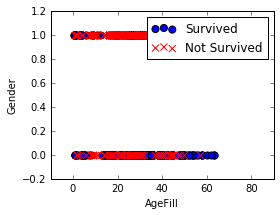

In [42]:
fig, ax = plt.subplots(figsize=(4,3))

ax.scatter(positive['AgeFill'], positive['Gender'], 
           s=50, c='b', marker='o', label='Survived') 
ax.scatter(negative['AgeFill'], negative['Gender'], 
           s=50, c='r', marker='x', label='Not Survived') 
ax.legend()  
ax.set_xlabel('AgeFill')  
ax.set_ylabel('Gender') 

### Definining functions required for Logistic regression 

In [43]:
### Definining functions required for Logistic regression 
def sigmoid(z):  
    return (1 / (1 + np.exp(-z)))

def cost(theta, X, y, learningRate=0):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    #first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    #second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    first = -y * np.log(sigmoid((X * theta.T)))
    second = (1-y) * np.log(1 - sigmoid(X * theta.T))
    reg = (learningRate / (2 * len(X))) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))

    return (first - second)[0,0] / len(X) + reg

def gradient(theta, X, y, learningRate=0):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    error = sigmoid(X * theta.T) - y
    for i in range(parameters):
        term = np.multiply(error, X[:,i])

        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])
    return grad

def predict(theta, X):  
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

### Feature engineering and scaling

In [44]:
def extract_variables(dFrame):
    X = np.array(dFrame.drop(['Survived'], axis=1).values)
    y = np.array(dFrame.Survived.values)
    return X, y

def scale(d):
    dFrame = d.copy(deep=True)
    scaler = MinMaxScaler()
    dFrame[['Pclass', 'Fare', 'AgeFill', 'Age*Class', 'SibSp', 'Parch', 'FamilySize', 'EmbarkedInt']] = scaler.fit_transform(dFrame[['Pclass', 'Fare', 'AgeFill', 'Age*Class', 'SibSp', 'Parch', 'FamilySize', 'EmbarkedInt']])
    return dFrame
    
def transform(d):
    dFrame = d.copy(deep=True)
    # Feature Engineering
    
    # Replacing Gender with Sex( binary mapping)
    dFrame['Gender'] = dFrame['Sex'].map({'male': 1, 'female': 0}).astype(int)
    ## calculating median of age and replacing all nulls
    dFrame['AgeFill'] = dFrame['Age'] 
    ## Storing where age is null
    dFrame['AgeIsNull'] = pd.isnull(dFrame.Age).astype(int)
    median_ages = np.zeros((2,3))
    for i in range(0, 2):
        for j in range(0, 3):
            median_ages[i,j] = dFrame[(dFrame['Gender'] == i) & \
                              (dFrame['Pclass'] == j+1)]['Age'].dropna().median()
    for i in range(0, 2):
        for j in range(0, 3):
            dFrame.loc[ (dFrame.Age.isnull()) & (dFrame.Gender == i) & (dFrame.Pclass == j+1),\
                'AgeFill'] = median_ages[i,j]

    # Additional features which me be predictive
    dFrame['FamilySize'] = dFrame['SibSp'] + dFrame['Parch']

    # As we know Pclass made a lot of effect on survival
    dFrame['Age*Class'] = dFrame.AgeFill * dFrame.Pclass
    
    dFrame['EmbarkedIsNull'] = pd.isnull(dFrame.Embarked).astype(int)
    dFrame.loc[dFrame.Embarked.isnull(), 'Embarked'] = 'S'
    dFrame['EmbarkedInt'] = dFrame['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    dFrame = dFrame.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', "Age"], axis=1) 
    # Adding 0th column
    dFrame.insert(0, 'Ones', 1)
    return dFrame

def run_logistic_regression(d, learningRate=0.01):
    # Initialize vectors, constants
    dFrame = d.copy(deep=True)    
    X, y = extract_variables(d)
    theta = np.random.rand(X.shape[1])    
    print("X.shape={0}, theta.shape={1}, y.shape={2}, len(X)={3}".format(X.shape, theta.shape, y.shape, len(X)))
    initial_cost = cost(theta,X, y, learningRate)
    print("Initial cost ={0}".format(initial_cost))
    print("Running minmisation function")
    result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y, learningRate)) 
    final_cost = cost(result[0], X, y, learningRate)
    print("Minimised cost = {0}".format(final_cost))   
    return result, initial_cost, final_cost



Plotting sigmoid function

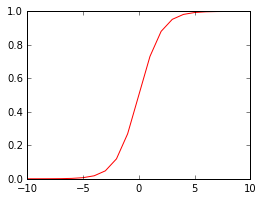

In [45]:
nums = np.arange(-10, 10, step=1)
fig, ax = plt.subplots(figsize=(4,3))  
ax.plot(nums, sigmoid(nums), 'r') 

### Train Data set and calculate accuracy

In [46]:
trainFrame = pd.read_csv('./data/train.csv', header=0)
trainFrame = transform(trainFrame)
trainFrame = scale(trainFrame)
result, initial_cost, final_cost = run_logistic_regression(trainFrame)
theta_min = np.matrix(result[0]) 
X,y  =  extract_variables(trainFrame)
predictions = predict(theta_min, X)  
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]  
accuracy = (sum(map(int, correct)) / len(correct)) * 100
print('Train accuracy = {0}%'.format(accuracy))


X.shape=(891, 12), theta.shape=(12,), y.shape=(891,), len(X)=891
Initial cost =1.209666730394602
Running minmisation function
Minimised cost = 0.6641967998554225
Train accuracy = 61.84062850729517%


In [47]:
init_testFrame = pd.read_csv('./data/test.csv', header=0)
init_testFrame.head()
testFrame = init_testFrame.copy(deep=True)    
testFrame.ix[152,'Fare'] = testFrame.Fare.median()

### Running Logistic Regression on test data

In [48]:
testFrame = transform(testFrame)
testFrame = scale(testFrame)
Xtest = np.array(testFrame.values)
predictions_test = predict(theta_min, Xtest)  

In [49]:
output =  pd.DataFrame({'PassengerId': init_testFrame.PassengerId, 'Survived':predictions_test})

In [50]:
output.groupby('Survived').size()

Survived
0    418
dtype: int64

In [51]:
output.to_csv('./data/output_{0}.csv'.format(accuracy), index=False)